In [1]:
#ARIMA library install
!pip install pmdarima

In [2]:
# import required libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
import seaborn as sns

# to read stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# for time stamps
from datetime import datetime


In [4]:
# Stocks we'll be using for Analysis
stockSymbol = ['TCS.NS','INFY.NS','HCLTECH.NS','WIPRO.NS']
stockList = ['TCS','INFOSYS','HCLTECH','WIPRO']

# Define start and end date of Historical data
endDate = datetime.now()
startDate = datetime(endDate.year - 1, endDate.month, endDate.day)

# Fecthing the data 
for stock,symbol in zip(stockList,stockSymbol):
    globals()[stock] = yf.download(symbol,startDate,endDate)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
for stock,symbol in zip(stockList,stockSymbol):
    globals()[stock] = yf.download(symbol,startDate,endDate)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Make a seperate dataframe for each of the stocks in the list
companyList = [TCS,INFOSYS,HCLTECH,WIPRO]
companyName = ["TCS","INFOSYS",'HCLTECH','WIPRO']

for company, name in zip(companyList,companyName):
    company["Company"] = name

df = pd.concat(companyList, axis=0)
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,
2021-06-14,3279.000000,3308.699951,3270.350098,3276.350098,3235.437256,1847360,TCS
2021-06-15,3298.000000,3298.000000,3251.550049,3262.750000,3222.006836,1304985,TCS
2021-06-16,3262.100098,3294.699951,3253.000000,3274.350098,3233.461914,1635552,TCS
2021-06-17,3265.500000,3336.050049,3260.000000,3317.750000,3276.320068,2273413,TCS
2021-06-18,3350.899902,3358.000000,3275.000000,3297.300049,3256.125488,3380431,TCS


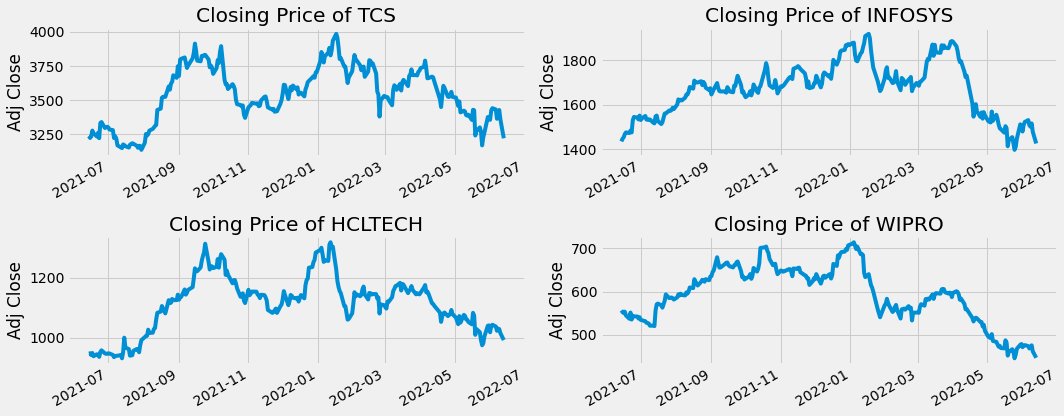

In [8]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(companyList, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stockList[i - 1]}")
    
plt.tight_layout()

In [21]:
#creating data frame with only closing price for a company
df_close = df[df['Company']=="WIPRO"]['Close']
df_close.head(5)

Date
2021-06-14    561.599976
2021-06-15    557.900024
2021-06-16    555.250000
2021-06-17    558.700012
2021-06-18    549.799988
Name: Close, dtype: float64

In [19]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

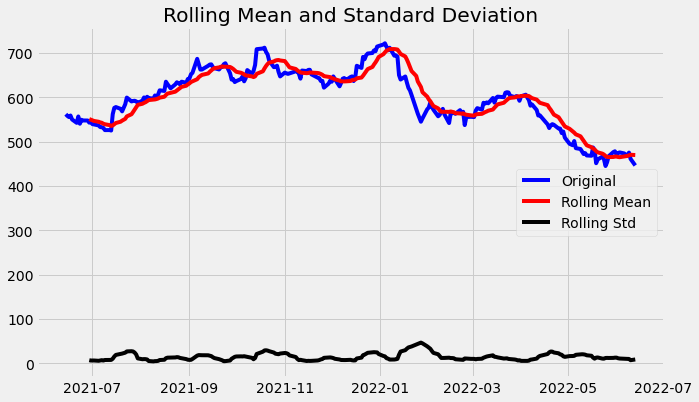

Results of dickey fuller test
Test Statistics                 -0.226727
p-value                          0.935260
No. of lags used                 0.000000
Number of observations used    248.000000
critical value (1%)             -3.456996
critical value (5%)             -2.873266
critical value (10%)            -2.573019
dtype: float64


In [22]:
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

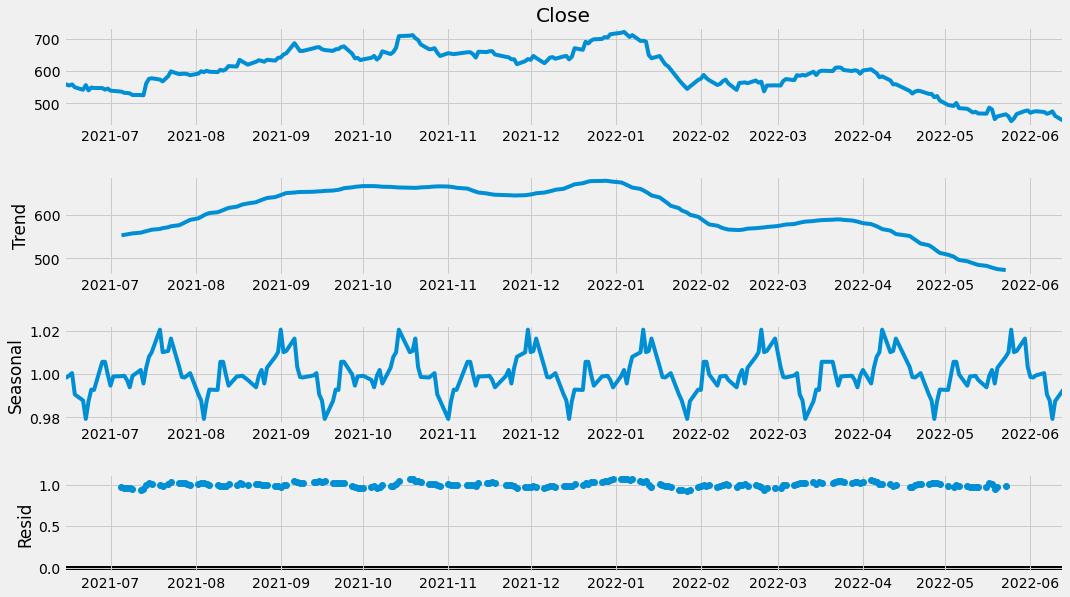

In [23]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


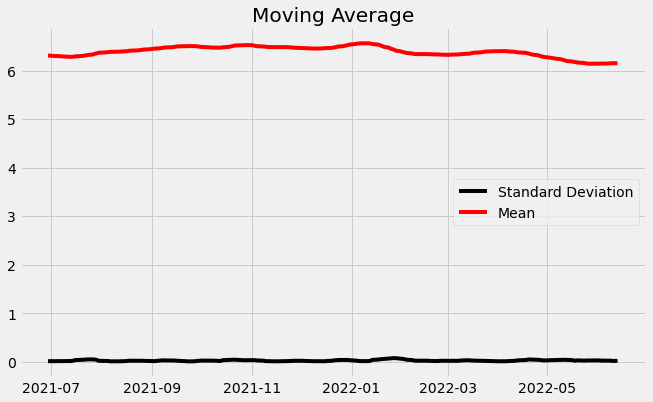

In [24]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

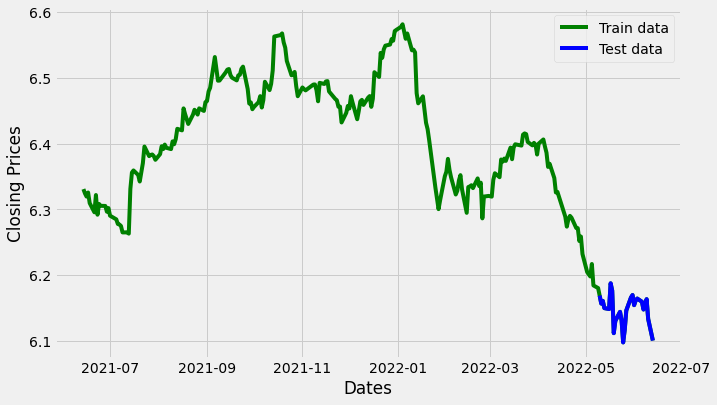

In [25]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1158.511, Time=1.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1156.713, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1156.702, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1160.188, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1154.707, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.684 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 581.094
Date:                Tue, 14 Jun 2022   AIC                          -1160.188
Time:                        06:05:47   BIC                          -1156.794
Sample:                             0   HQIC                         -1158.818
                                - 221                                  

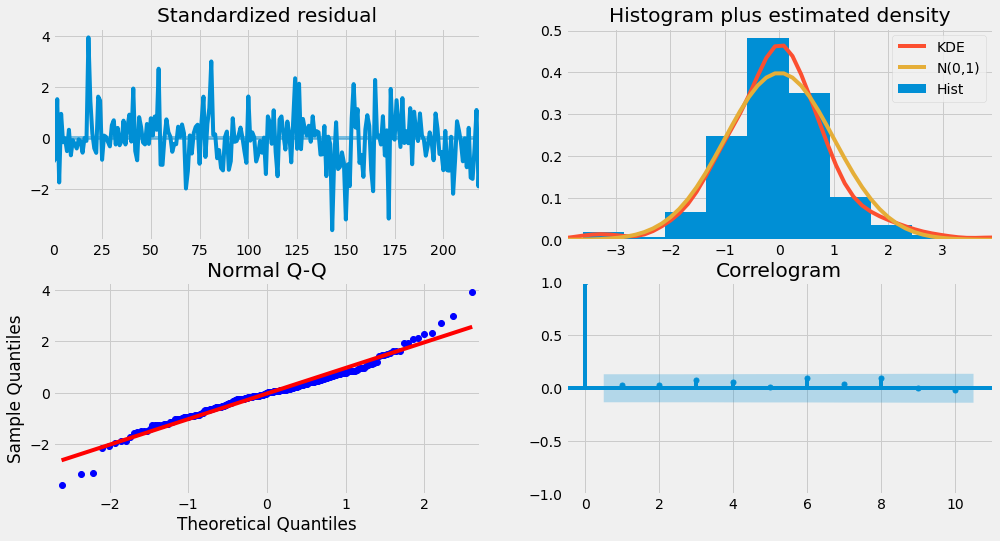

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [27]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\Aayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Aayush\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 582.705
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 14 Jun 2022   AIC                          -1155.410
Time:                        06:06:05   BIC                          -1138.442
Sample:                             1   HQIC                         -1148.558
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0008      0.002     -0.484      0.628      -0.004       0.002
ar.L1.D.Close     0.8598      0.118      7.309      0.000       0.629       1.090
ma.L1.D.Close    -0.8456      0.135     

C:\Users\Aayush\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# Forecast
fc, se, conf = fitted.forecast(25, alpha=0.05)  # 95% conf

print(len(fc))
print(len(train_data.index))
train_data.index

25
221


DatetimeIndex(['2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30',
               ...
               '2022-04-25', '2022-04-26', '2022-04-27', '2022-04-28',
               '2022-04-29', '2022-05-02', '2022-05-04', '2022-05-05',
               '2022-05-06', '2022-05-09'],
              dtype='datetime64[ns]', name='Date', length=221, freq=None)

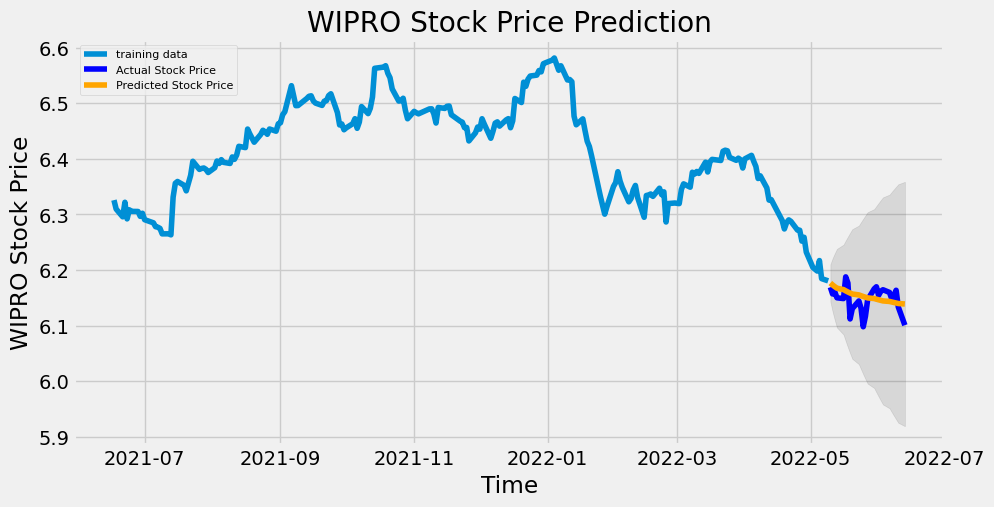

In [45]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('WIPRO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('WIPRO Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0005400773340405057
MAE: 0.019663810560443657
RMSE: 0.023239563981290734
MAPE: 0.0032031165734292305
